In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,7)})

In [2]:
#load data
data = pd.read_csv("..\..\..\Data\Day\S&P 500 Historical Data00-20Linear.csv")

In [3]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date)
data = data.sort_values(by=["Date"])
data.set_index('Date')
data.Price = data.Price.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)
data["Vol."] = data["Vol."].astype(float)

In [4]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
1,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
2,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
3,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
4,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [5]:
data.index = data.index[::-1]

In [6]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
7255,2000-01-03,1455.2,1469.2,1478.0,1438.4,NaN,-0.95%
7254,2000-01-04,1399.4,1455.2,1455.2,1397.4,NaN,-3.83%
7253,2000-01-05,1402.1,1399.4,1413.3,1377.7,NaN,0.19%
7252,2000-01-06,1403.5,1402.1,1411.9,1392.0,NaN,0.10%
7251,2000-01-07,1441.5,1403.5,1441.5,1400.5,NaN,2.71%


In [7]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2014-01-01')]
special_data.index = data.index[:len(special_data)]

In [8]:
special_data.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
7255,2010-01-02,1124.045000,1121.580000,1130.7550,1115.685000,NaN,NaN
7254,2010-01-03,1128.517500,1119.070000,1132.3125,1116.122500,NaN,NaN
7253,2010-01-04,1132.990000,1116.560000,1133.8700,1116.560000,NaN,1.60%
7252,2010-01-05,1136.520000,1132.660000,1136.6300,1129.660000,NaN,0.31%
7251,2010-01-06,1137.140000,1135.710000,1139.1900,1133.950000,NaN,0.05%
7250,2010-01-07,1141.690000,1136.270000,1142.4600,1131.320000,NaN,0.40%
7249,2010-01-08,1144.980000,1140.520000,1145.3900,1136.220000,NaN,0.29%
7248,2010-01-09,1145.646667,1142.333333,1146.8400,1138.153333,NaN,NaN
7247,2010-01-10,1146.313333,1144.146667,1148.2900,1140.086667,NaN,NaN
7246,2010-01-11,1146.980000,1145.960000,1149.7400,1142.020000,NaN,0.17%


In [9]:
#change indexes
special_data.set_index('Date', inplace=True)

In [10]:
special_data = special_data.drop(columns=['Open', 'High', 'Low', 'Vol.', 'Change %'])

In [11]:
special_data.head()

,Price
Date,
2010-01-02,1124.0450
2010-01-03,1128.5175
2010-01-04,1132.9900
2010-01-05,1136.5200
2010-01-06,1137.1400


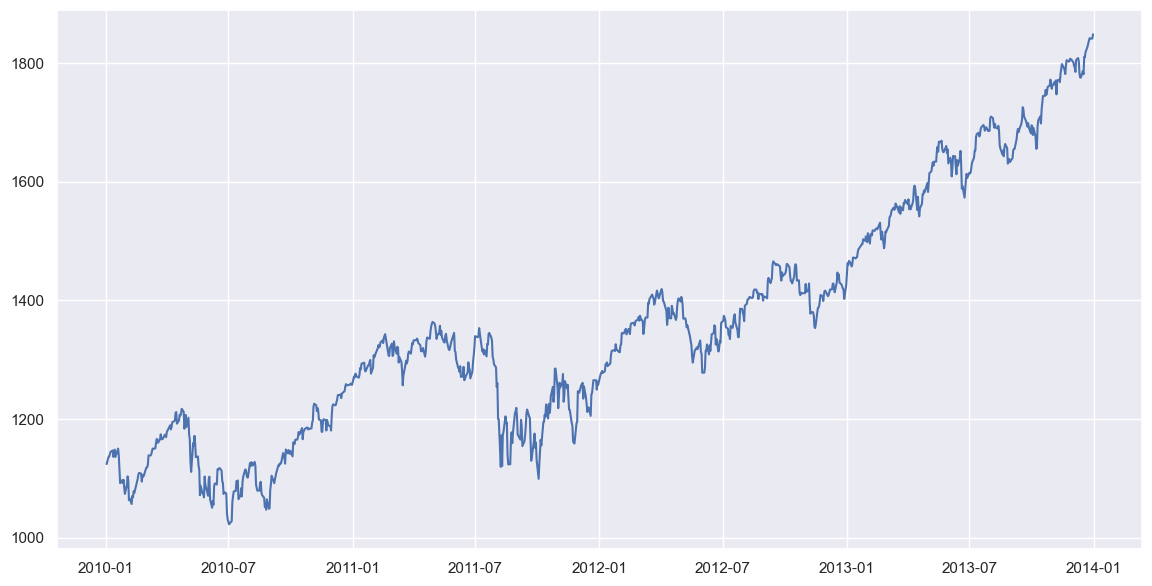

In [12]:
plt.plot(special_data)

In [13]:
special_data.rename(columns={'Price': 'Close'}, inplace=True)

In [14]:
from scalecast.Forecaster import Forecaster
f = Forecaster(y = special_data['Close'], 
               current_dates = special_data.index)

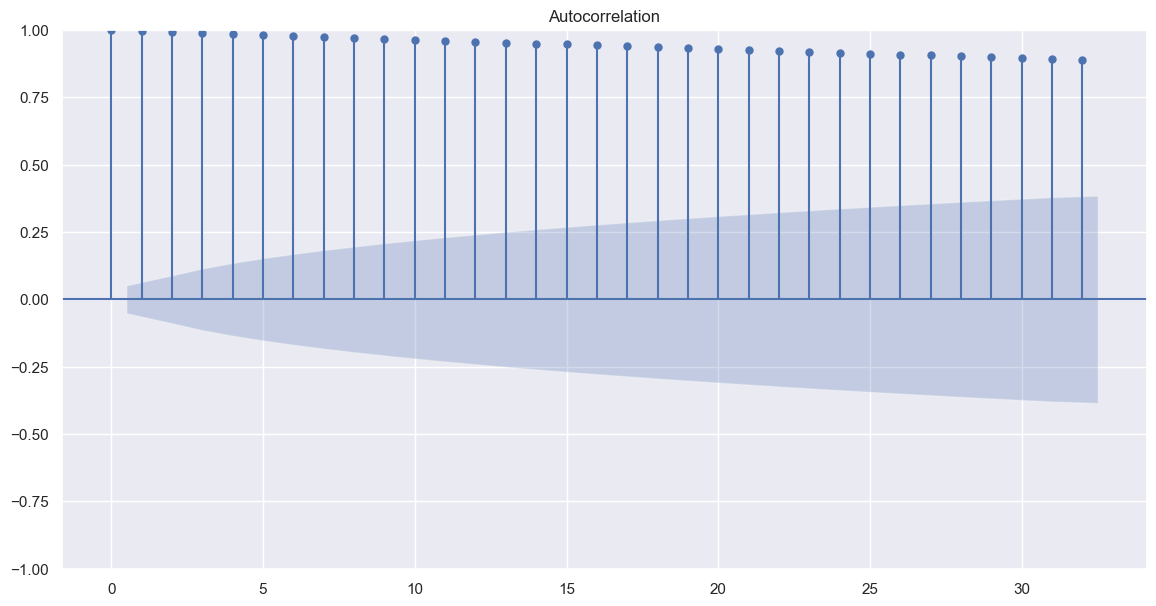

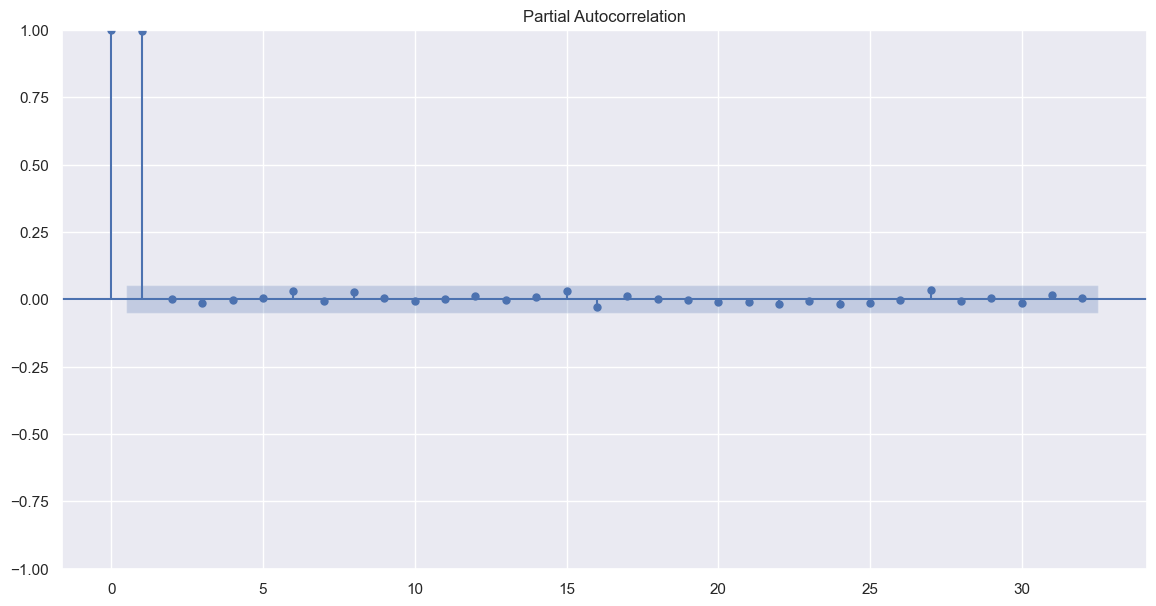

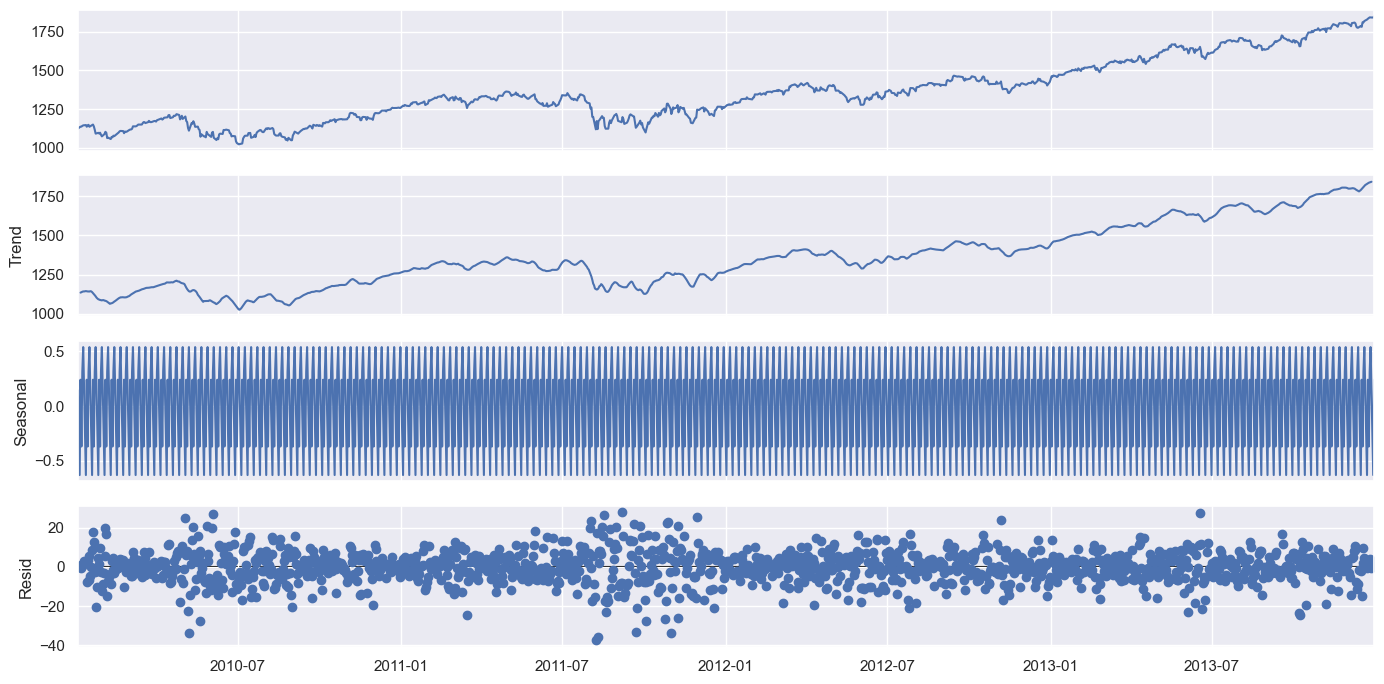

0.43496219012788145
0.9827563572005192


In [15]:
# EDA
f.plot_acf()
plt.show()
f.plot_pacf()
plt.show()
f.seasonal_decompose().plot()
plt.show()
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print(stat)
print(pval)

In [16]:
# Forecast
f.manual_forecast(order=(2,1,1),seasonal_order=(2,1,1,12),call_me='arima2')

# View test results
f.plot_test_set(ci = True,models='arima2')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

# View forecast results
f.plot(ci = True, models = 'arima2')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

# See summary stats
f.regr.summary()

ForecastError: Before calling a model, please make sure you have generated future dates by calling generate_future_dates(), set_last_future_date(), or ingest_Xvars_df(use_future_dates=True).

In [44]:
# Разделение данных на train и test
train_size = int(0.9 * len(special_data))  # 80% данных для обучения
train_data = pd.DataFrame({
    'ds': special_data.iloc[:train_size].index,
    'y' : special_data.iloc[:train_size].Close})
test_data = pd.DataFrame({
    'ds': special_data.iloc[train_size:].index,
    'y' : special_data.iloc[train_size:].Close})

In [45]:
train_size

1314

In [46]:
from prophet import Prophet

# Создание и обучение модели Prophet
model = Prophet(daily_seasonality = False)  # Указываем, что у нас есть ежедневная сезонность
model.fit(train_data.reset_index())

19:55:23 - cmdstanpy - INFO - Chain [1] start processing
19:55:23 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
# Создание фрейма для прогнозирования
future = pd.DataFrame(index = test_data.index)
future['ds'] = test_data.index

In [48]:
# Получение прогнозов
forecast = model.predict(future)

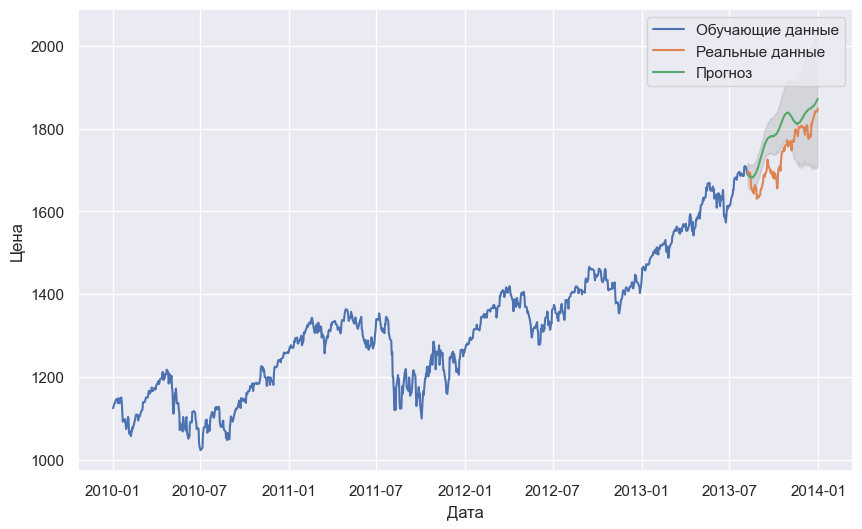

In [49]:
# Визуализация результатов
fig = plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['y'], label='Обучающие данные')
plt.plot(test_data.index, test_data['y'], label='Реальные данные')
plt.plot(test_data.index, forecast['yhat'], label='Прогноз')
plt.fill_between(test_data.index, forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha = 0.2)
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [50]:
def calculate_metrics(array1, array2):
    # Проверка на совпадение длин массивов
    if len(array1) != len(array2):
        raise ValueError("Длины массивов должны совпадать")

    # Вычисление отклонений
    deviations = np.abs(np.array(array1) - np.array(array2))

    # Минимальное и максимальное отклонение
    min_deviation = np.min(deviations)
    max_deviation = np.max(deviations)

    # Процентное минимальное и максимальное отклонение
    min_deviation_percentage = min_deviation / np.max(np.abs(array1)) * 100
    max_deviation_percentage = max_deviation / np.max(np.abs(array1)) * 100
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(deviations / np.abs(array1)) * 100

    return min_deviation, max_deviation, min_deviation_percentage, max_deviation_percentage, mape


In [51]:
min_dev, max_dev, min_dev_percentage, max_dev_percentage, mape = calculate_metrics(test_data['y'].values, forecast['yhat'])

print(f"Минимальное отклонение: {min_dev}")
print(f"Максимальное отклонение: {max_dev}")
print(f"Процентное минимальное отклонение: {min_dev_percentage:.2f}%")
print(f"Процентное максимальное отклонение: {max_dev_percentage:.2f}%")
print(f"MAPE: {mape:.2f}%")

Минимальное отклонение: 2.9903333591391856
Максимальное отклонение: 135.13825519498755
Процентное минимальное отклонение: 0.16%
Процентное максимальное отклонение: 7.31%
MAPE: 3.27%


In [52]:
len(special_data)

1460

In [53]:
len(train_data['y'])

1314

In [54]:
len(test_data['y'])

146

In [55]:
def save_array_to_txt(array, filename):
    # Преобразуем одномерный массив в двумерный массив с одним столбцом
    array = np.reshape(array, (len(array), 1))
    
    # Сохраняем массив в текстовый файл
    np.savetxt(filename, array, fmt='%.3f')  # fmt='%d' указывает формат данных (целые числа)


In [56]:
save_array_to_txt(forecast['yhat'].values, "prop90linear.txt")